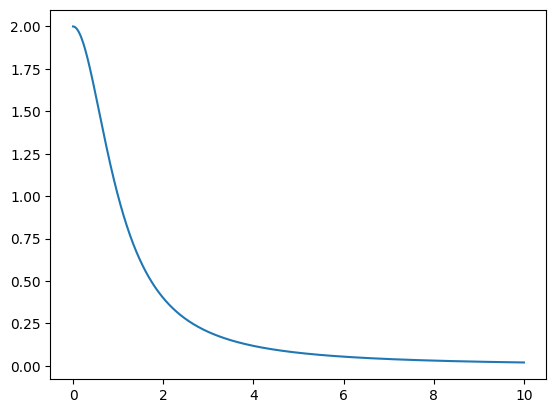

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# class Diff_Eq:
    
#     x0 = 0.0
    
#     @staticmethod
#     def y_prime(x, y):
#         return torch.sin(x) + torch.cos(y)
    
#     @staticmethod
#     def y0():
#         return 3.0
    
#     @staticmethod
#     def y(x):
#         return torch.sin(x) - torch.cos(x) + 4.0

# y' = - x y^2 という微分方程式を解く
class Diff_Eq:
    
    x0 = 1.
    
    @staticmethod
    def y_prime(x, y):
        return - x * y ** 2
    
    @staticmethod
    def y0():
        return 1.0
    
    @staticmethod
    def y(x):
        return 2 / (1 + x ** 2)


    
# class Diff_Eq:
    
#     x0 = 0.0
    
#     @staticmethod
#     def y_prime(x, y):
#         return - 2 * x * y
    
#     @staticmethod
#     def y0():
#         return 1.0
    
#     @staticmethod
#     def y(x):
#         return torch.exp(- x ** 2) 
    
# 解を描画
x = torch.linspace(0, 10, 1000)
y = Diff_Eq.y(x)
plt.plot(x, y)
plt.show()


In [2]:
class EqDataset(torch.utils.data.Dataset):
    
    def __init__(self,x_from=0, x_to=8,length = 300000):
        
        self.x_from = x_from
        self.x_to = x_to
        self.length = length
        
        return 
    
    def __len__(self):
        
        return self.length
    
    def __getitem__(self, idx):
        
        x = torch.rand(1) * (self.x_to - self.x_from) + self.x_from
        
        return x
    
dataset = EqDataset()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True)

In [3]:
from distutils.command import build


class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        def build_layers(in_features, out_features):
            return nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.Tanh()
            )
        
        self.fc = nn.Sequential(
            build_layers(1, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            nn.Linear(20, 1)
        )
        
        return 
    
    def forward(self, x):
        
        return self.fc(x)

    

epoch: 0


100%|██████████| 300/300 [00:04<00:00, 60.37it/s]


loss_mse: 0.014821608907465512
loss_init: 0.13902227985349563
loss_total: 0.016211831692877845
epoch: 1


100%|██████████| 300/300 [00:04<00:00, 71.33it/s]


loss_mse: 0.00026245935847934255
loss_init: 0.00017661305852129772
loss_total: 0.0002642254894484116
epoch: 2


100%|██████████| 300/300 [00:04<00:00, 69.94it/s]


loss_mse: 5.847415891366836e-06
loss_init: 2.732765289377899e-06
loss_total: 5.8747435309669525e-06
epoch: 3


100%|██████████| 300/300 [00:04<00:00, 69.06it/s]


loss_mse: 1.6275239958455737e-06
loss_init: 1.4490092643389591e-07
loss_total: 1.6289730092466924e-06
epoch: 4


100%|██████████| 300/300 [00:04<00:00, 71.01it/s]


loss_mse: 8.979310609902313e-07
loss_init: 7.948943063477524e-08
loss_total: 8.9872595651741e-07
epoch: 5


100%|██████████| 300/300 [00:04<00:00, 69.99it/s]


loss_mse: 7.605346502259636e-07
loss_init: 1.738628148710101e-07
loss_total: 7.622732787619194e-07


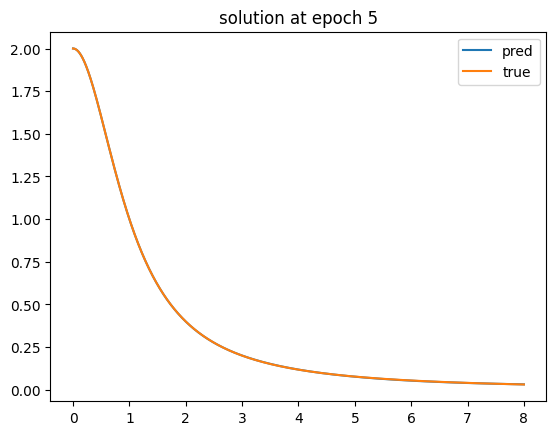

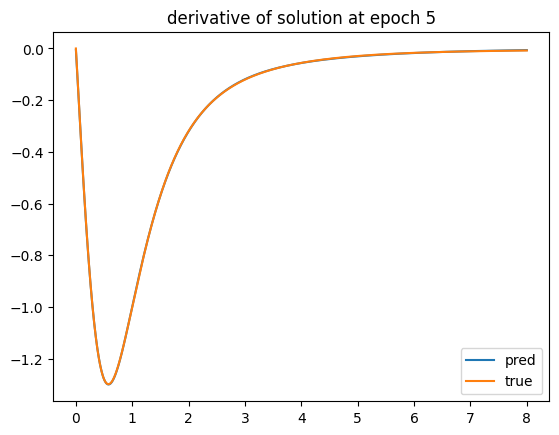

In [4]:
from traceback import print_tb




model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 6

loss_list = {
    "mse": [],
    "init": [],
    "total": []
}

for epoch in range(num_epochs):
    
    print(f"epoch: {epoch}")
    
    loss_list["mse"].append(0)
    loss_list["init"].append(0)
    loss_list["total"].append(0)
    
    from tqdm import tqdm
    
    for x in tqdm(dataloader):
        
        
        optimizer.zero_grad()
        
        x : torch.Tensor = x.to(device)
        x.requires_grad = True
        y_prime : torch.Tensor = Diff_Eq.y_prime(x, Diff_Eq.y(x))
        
        y_pred: torch.Tensor = model(x)
        

        y_prime_pred = torch.autograd.grad(y_pred.sum(), x, create_graph=True)[0]
        
        # print(y_prime_pred)
        
        loss_mse = F.mse_loss(y_prime_pred, y_prime)

        
        y0_pred  = model(torch.tensor([[Diff_Eq.x0]]).to(device))
        y0_true = torch.tensor([[Diff_Eq.y0()]]).to(device)
        loss_init = (y0_pred - y0_true) ** 2
        
        loss = loss_mse + loss_init * 0.01
        loss.backward()
        
        optimizer.step()
        
        loss_list["mse"][-1] += loss_mse.item()
        loss_list["init"][-1] += loss_init.item()
        loss_list["total"][-1] += loss.item()
    
    loss_list["mse"][-1] /= len(dataloader)
    loss_list["init"][-1] /= len(dataloader)
    loss_list["total"][-1] /= len(dataloader)
    
    print(f"loss_mse: {loss_list['mse'][-1]}")
    print(f"loss_init: {loss_list['init'][-1]}")
    print(f"loss_total: {loss_list['total'][-1]}")
    
    # val_x = torch.linspace(dataloader.dataset.x_from, dataloader.dataset.x_to, 1000).to(device).view(-1, 1)
    # val_x.requires_grad = True
    # val_y = model(val_x)
    
    # plt.plot(val_x.cpu().detach().numpy(), val_y.cpu().detach().numpy(), label="pred")
    # plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y(val_x).cpu().detach().numpy(), label="true")
    # plt.legend() 
    # plt.title(f"solution at epoch {epoch}")
    # plt.show()
    
    
    # # 微分値についても描画
    # val_y_prime = torch.autograd.grad(val_y.sum(), val_x, create_graph=True)[0]
    # plt.plot(val_x.cpu().detach().numpy(), val_y_prime.cpu().detach().numpy(), label="pred")
    # plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y_prime(val_x, val_y).cpu().detach().numpy(), label="true")
    # plt.legend()
    # plt.title(f"derivative of solution at epoch {epoch}")
    # plt.show()


val_x = torch.linspace(dataloader.dataset.x_from, dataloader.dataset.x_to, 1000).to(device).view(-1, 1)
val_x.requires_grad = True
val_y = model(val_x)

plt.plot(val_x.cpu().detach().numpy(), val_y.cpu().detach().numpy(), label="pred")
plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y(val_x).cpu().detach().numpy(), label="true")
plt.legend() 
plt.title(f"solution at epoch {epoch}")
plt.show()


# 微分値についても描画
val_y_prime = torch.autograd.grad(val_y.sum(), val_x, create_graph=True)[0]
plt.plot(val_x.cpu().detach().numpy(), val_y_prime.cpu().detach().numpy(), label="pred")
plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y_prime(val_x, val_y).cpu().detach().numpy(), label="true")
plt.legend()
plt.title(f"derivative of solution at epoch {epoch}")
plt.show()
